In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#pip install tensorflow

In [3]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Function to get dataset path from mounted Google Drive
#def get_dataset_path(drive_path):
 #   full_path = os.path.join('/content/drive/My Drive', drive_path)
  #  if not os.path.exists(full_path):
   #     raise FileNotFoundError(f"Dataset not found at {full_path}. Please check the path.")
    #return full_path

In [5]:
# Define the Q-learning agent (same as before)
class QLearningAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros((state_size, action_size))
        self.learning_rate = 0.01
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        return np.argmax(self.q_table[state, :])

    def update(self, state, action, reward, next_state):
        target = reward + self.gamma * np.max(self.q_table[next_state, :])
        self.q_table[state, action] = (1 - self.learning_rate) * self.q_table[state, action] + self.learning_rate * target
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [6]:
# Load and preprocess image data
def load_and_preprocess_data(drive_path, img_height, img_width, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_ds = train_datagen.flow_from_directory(
        drive_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        subset='training',
        shuffle=True
    )

    val_ds = train_datagen.flow_from_directory(
        drive_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation',
        shuffle=False
    )

    class_names = list(train_ds.class_indices.keys())

    return train_ds, val_ds, class_names

In [7]:
# Build CNN model
def build_cnn_model(img_height, img_width, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(img_height, img_width, 3)),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [8]:
# Train the model
def train_model(model, train_ds, val_ds, epochs):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=len(train_ds),
        validation_steps=len(val_ds)
    )
    return history

In [9]:
# Evaluate the model
def evaluate_model(model, val_ds):
    loss, accuracy = model.evaluate(val_ds, steps=len(val_ds))
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

    val_ds.reset()
    y_pred = model.predict(val_ds, steps=len(val_ds))
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_ds.classes

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred_classes))

In [10]:
# Reinforce CNN predictions using Q-learning
def reinforce_predictions(agent, model, val_ds):
    reinforced_predictions = []
    true_labels = []

    val_ds.reset()
    for _ in range(len(val_ds)):
        images, labels = next(val_ds)
        batch_predictions = model.predict(images)
        for j in range(len(labels)):
            cnn_prediction = batch_predictions[j].argmax()
            state = cnn_prediction
            action = agent.get_action(state)
            reinforced_prediction = action
            reinforced_predictions.append(reinforced_prediction)
            true_labels.append(labels[j])

            reward = 1 if reinforced_prediction == labels[j] else -1
            next_state = reinforced_prediction
            agent.update(state, action, reward, next_state)

    return np.array(reinforced_predictions), np.array(true_labels)

In [11]:
# Visualize training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
# Main function
def main():
    # Set parameters
    #drive_path =  "/content/drive/MyDrive/Sickle-Cell-Anemia-Images" # Replace with your dataset path in Google Drive
    #drive_path = "D:/Sickle-Cell-Anemia-Images"
    drive_path = "D:\Sajiddata\SCA"
    img_height = 180
    img_width = 180
    batch_size = 32
    epochs = 65

    # Get the dataset path from mounted Google Drive
    # data_dir = get_dataset_path(drive_path)

    # Load and preprocess data
    train_ds, val_ds, class_names = load_and_preprocess_data(drive_path, img_height, img_width, batch_size)

    # Build and train CNN model
    num_classes = len(class_names)
    model = build_cnn_model(img_height, img_width, num_classes)
    history = train_model(model, train_ds, val_ds, epochs)

    # Evaluate CNN model
    print("CNN Model Evaluation:")
    evaluate_model(model, val_ds)

    # Initialize Q-learning agent
    agent = QLearningAgent(state_size=num_classes, action_size=num_classes)

    # Reinforce predictions
    reinforced_predictions, true_labels = reinforce_predictions(agent, model, val_ds)

    # Evaluate reinforced predictions
    print("\nReinforced Model Evaluation:")
    print("\nClassification Report:")
    print(classification_report(true_labels, reinforced_predictions))
    print("\nConfusion Matrix:")
    print(confusion_matrix(true_labels, reinforced_predictions))

    # Plot training history
    plot_training_history(history)

Found 10455 images belonging to 2 classes.
Found 2613 images belonging to 2 classes.


C:\Users\gpu.sajid\.conda\envs\ImageTesting\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/65
327/327 ━━━━━━━━━━━━━━━━━━━━ 188s 573ms/step - accuracy: 0.7483 - loss: 0.6966 - val_accuracy: 0.7750 - val_loss: 0.5157
Epoch 2/65
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 105us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/65


C:\Users\gpu.sajid\.conda\envs\ImageTesting\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


327/327 ━━━━━━━━━━━━━━━━━━━━ 168s 513ms/step - accuracy: 0.7851 - loss: 0.4715 - val_accuracy: 0.8113 - val_loss: 0.2579
Epoch 4/65
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/65
327/327 ━━━━━━━━━━━━━━━━━━━━ 168s 512ms/step - accuracy: 0.7990 - loss: 0.4070 - val_accuracy: 0.8768 - val_loss: 0.1988
Epoch 6/65
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 57us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/65
327/327 ━━━━━━━━━━━━━━━━━━━━ 168s 514ms/step - accuracy: 0.8027 - loss: 0.4024 - val_accuracy: 0.8385 - val_loss: 0.2670
Epoch 8/65
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 36us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/65
327/327 ━━━━━━━━━━━━━━━━━━━━ 169s 516ms/step - accuracy: 0.8193 - loss: 0.3702 - val_accuracy: 0.8668 - val_loss: 0.1968
Epoch 10/65
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/65
327/327 ━━━━━━━━━━━━━━━━━━━━ 168s 515ms/step - accuracy: 0.8265 - loss: 0.3650 - val_accur

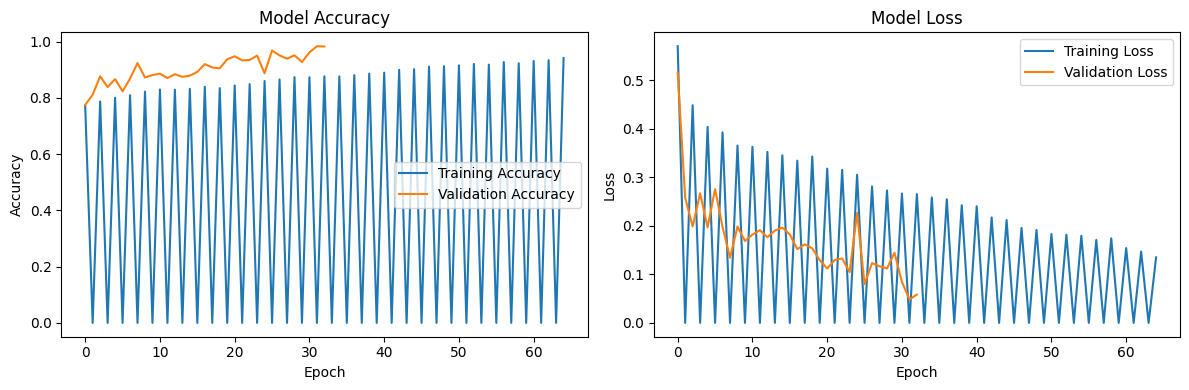

In [13]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
if __name__ == "__main__":
    main()